In [23]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

### Используем ряд Weekly-closings-of-the-dowjones

In [9]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv").Close
series = np.array(series)

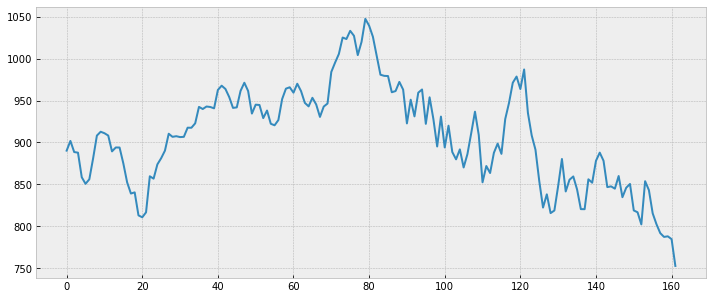

In [25]:
with plt.style.context(style='bmh'):
    fig = plt.figure(figsize=(12,5))
    plt.plot(series)

### Train test split

In [10]:
#test
test_size = .15
train_length = int( len(series) * (1- test_size) )

X_train, X_test  = series[:train_length] , series[train_length :] 

### ARIMA

In [6]:
#cros val arima

best_params = (0,0,0)
best_mse = np.inf

for p in tqdm(range(7)):
    for d in range(2):
        for q in range(7):
            model = ARIMA(X_train,order=(p,d,q), trend='n')
            res = model.fit(method_kwargs = {'maxiter':300}, method='statespace')
            if res.mse < best_mse:
                best_mse = res.mse
                best_params = (p,d,q)

best_params, best_mse

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


((6, 0, 6), 5234.096938070663)

In [30]:
model = ARIMA(X_train,order=best_params, trend='n')
res_1 = model.fit(method_kwargs = {'maxiter':300}, method='statespace')
res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  137
Model:                 ARIMA(6, 0, 6)   Log Likelihood                -591.100
Date:                Wed, 11 Aug 2021   AIC                           1208.201
Time:                        14:19:14   BIC                           1246.160
Sample:                             0   HQIC                          1223.627
                                - 137                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4403      0.446      0.987      0.324      -0.434       1.315
ar.L2          1.5902      0.489      3.251      0.001       0.632       2.549
ar.L3         -0.5562      0.424     -1.312      0.189      -1.387       0.275
ar.L4         -1.3680      0.561     -2.440      0.015      -2.467      -0.269
ar.L5          0.3418      0.261      1.310      0.190      -0.170       0.853
ar.L6          0.5515      0.353      1.562      0.118      -0.140       1.243
ma.L1          0.5866     42.999      0.014      0.989     -83.689      84.862
ma.L2         -1.1000     17.599     -0.063      0.950     -35.594      33.394
ma.L3         -0.2989     43.084     -0.007      0.994     -84.742      84.144
ma.L4          1.0768     17.619      0.061      0.951     -33.457      35.610
ma.L5          0.4073      0.414      0.984      0.325      -0.404       1.219
ma.L6         -0.0033      0.178     -0.019      0.985      -0.352       0.346
sigma2       286.0623      0.389    734.534      0.000     285.299     286.826
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.94   Prob(JB):                         0.98
Heteroskedasticity (H):               2.26   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.71e+20. Standard errors may be unstable.
"""

#### Результаты по ARIMA:

    - Ни один коеффициент MA статистически не значим
    - Большое значение имеет 2 и 4 AR коэффициент
 
Посмотрим на график остатков:

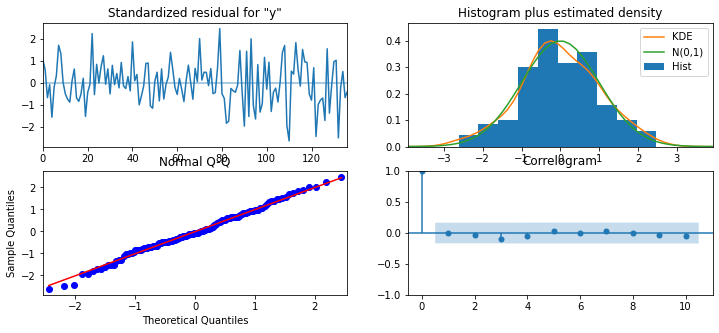

In [31]:
res_1.plot_diagnostics(figsize=(12,5));

График остатков похож на нормальное распределение

### GARCH

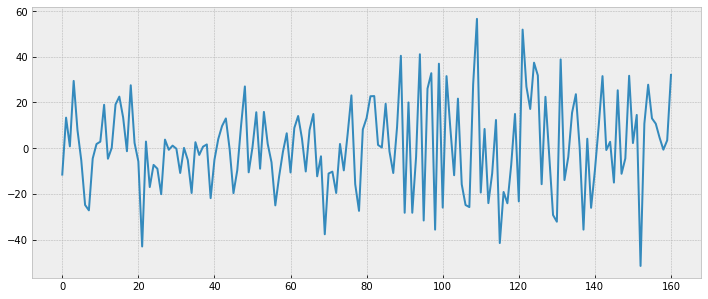

In [69]:
with plt.style.context(style='bmh'):
    fig = plt.figure(figsize=(12,5))
    series = series[:-1]-series[1:]
    plt.plot(series)

In [70]:
#garch
p_,o_,q_  = best_params
print(best_params)

# Using student T distribution usually provides better fit
am = arch_model(X_train, p=p_, o=o_, q=q_, dist='StudentsT')
res_2 = am.fit(update_freq=5, disp='off')
res_2.summary()

(6, 0, 6)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -701.537
Distribution:      Standardized Student's t   AIC:                           1433.07
Method:                  Maximum Likelihood   BIC:                           1476.87
                                              No. Observations:                  137
Date:                      Wed, Aug 11 2021   Df Residuals:                      136
Time:                              14:45:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           941.4203      5.050    186.438      0.000 [9.315e+02,9.513e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        217.9324   3569.251  6.106e-02      0.951 [-6.778e+03,7.214e+03]
alpha[1]       0.8391      0.159      5.282  1.277e-07      [  0.528,  1.150]
alpha[2]       0.1152      8.580  1.343e-02      0.989      [-16.701, 16.931]
alpha[3]   2.5414e-14      5.789  4.390e-15      1.000      [-11.346, 11.346]
alpha[4]       0.0326      0.263      0.124      0.902      [ -0.484,  0.549]
alpha[5]   4.2029e-15      2.397  1.753e-15      1.000      [ -4.698,  4.698]
alpha[6]   7.5995e-03      0.384  1.980e-02      0.984      [ -0.745,  0.760]
beta[1]        0.0000      9.934      0.000      1.000      [-19.470, 19.470]
beta[2]    2.0864e-14      5.691  3.666e-15      1.000      [-11.154, 11.154]
beta[3]    1.0161e-14      0.466  2.182e-14      1.000      [ -0.913,  0.913]
beta[4]    1.5451e-14      2.246  6.880e-15      1.000      [ -4.402,  4.402]
beta[5]    1.9087e-14      0.699  2.732e-14      1.000      [ -1.369,  1.369]
beta[6]    8.2738e-14      0.348  2.380e-13      1.000      [ -0.681,  0.681]
                                Distribution                                
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
nu           499.6720    180.360      2.770  5.598e-03 [1.462e+02,8.532e+02]
============================================================================

Covariance estimator: robust
"""

#### Результаты по GARCH:

    - Ни один коеффициент alpha(кроме первого коеффициента) статистически не значимы
    - Ни один коеффициент betta (при предыдущей сигме) статистически не значимы (модель GARCH их занулила)
    - alpha0 тоже не значима
 
Посмотрим на график остатков:

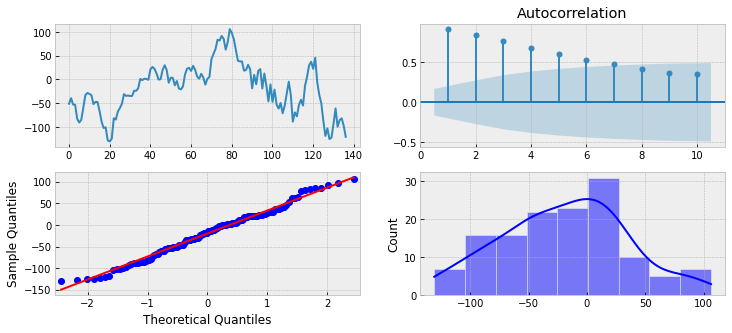

In [71]:
y= res_2.resid

with plt.style.context(style='bmh'):
    fig = plt.figure(figsize=(12,5))
    ax= fig.add_subplot(221)
    plt.plot(y)

    ax2= fig.add_subplot(222)
    smt.graphics.plot_acf(y, lags=10, ax=ax2, alpha=0.05, zero=False)

    ax3= fig.add_subplot(223)
    sm.qqplot(y, line='s', ax=ax3)

    ax4= fig.add_subplot(224)
    sns.histplot(y, kde=True, ax=ax4)

График остатков похож на нормальное распределение.  
Но есть сильная корреляциян на первых лагах

### Проверка на валидационной выборке ARIMA, GARCH

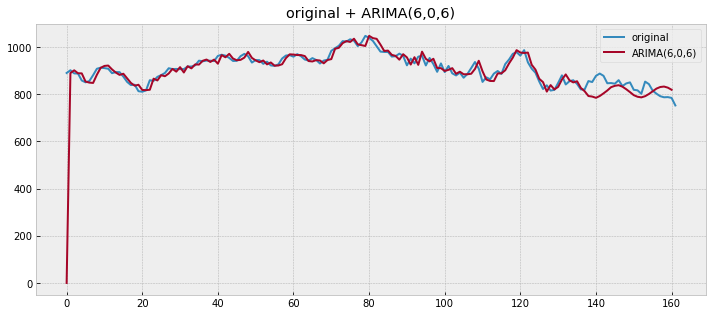

In [33]:
with plt.style.context(style='bmh'):
    fig = plt.figure(figsize=(12,5))
    plt.plot(series,label='original')
    plt.plot(range(0,161),res_1.predict(0,160),label='ARIMA(6,0,6)' )
    plt.legend()
    plt.title('original + ARIMA(6,0,6)')

In [ ]:
import random
random.seed(255)

eps = np.random.normal(size=len(X_test))*.2
new_stds = (res_2.forecast(horizon=len(X_test)).variance.dropna().values)**.5
y_pred = eps * new_stds[0]

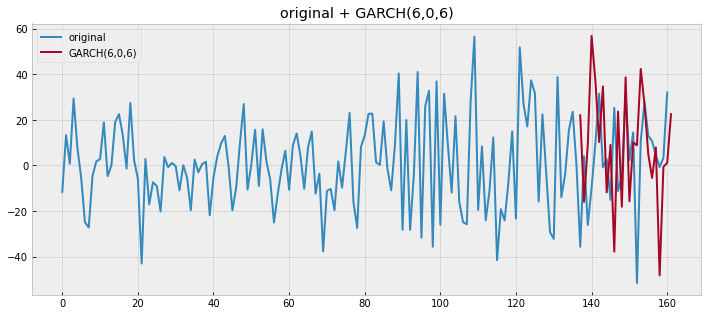

In [88]:
with plt.style.context(style='bmh'):
    fig = plt.figure(figsize=(12,5))
    plt.plot(series,label='original')
    
    plt.plot(range(len(X_train),len(series)+1),y_pred,label='GARCH(6,0,6)' )
    plt.legend()
    plt.title('original + GARCH(6,0,6)')